In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#### 1. Load model and data

In [2]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘./data’: File exists
--2020-06-02 10:48:23--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.32.42.151, 13.32.42.53, 13.32.42.39, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.32.42.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23,55K  --.-KB/s    in 0,004s  

2020-06-02 10:48:24 (5,96 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2020-06-02 10:48:24--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8000::4, 2620:12a:8001::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, awaiting

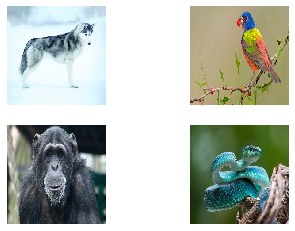

In [3]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img)
  plt.axis('off')

In [8]:
model = ResNet50(weights='imagenet')

./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662036), ('n02109961', 'Eskimo_dog', 0.41737312), ('n02110063', 'malamute', 0.020951591)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.3013896), ('n01537544', 'indigo_bunting', 0.16979557), ('n01828970', 'bee_eater', 0.16134162)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.51498663), ('n02480495', 'orangutan', 0.15896694), ('n02480855', 'gorilla', 0.15318146)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.42379618), ('n03627232', 'knot', 0.0905097), ('n01749939', 'green_mamba', 0.06557761)]


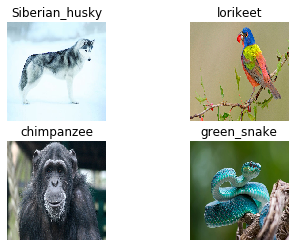

In [9]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(decode_predictions(preds, top=3)[0][0][1])

Checkpoint. Save model

In [6]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [7]:
model = tf.keras.models.load_model('resnet50_saved_model')

#### 2. Test base model prediction on singe image and banchmark speed

./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662036), ('n02109961', 'Eskimo_dog', 0.41737312), ('n02110063', 'malamute', 0.020951591)]


Text(0.5, 1.0, 'Siberian_husky')

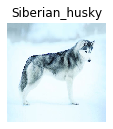

In [10]:
# Test prediction on singe image

img_path = './data/img0.JPG'  # Siberian_husky
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
plt.subplot(2,2,1)
plt.imshow(img)
plt.axis('off')
plt.title(decode_predictions(preds, top=3)[0][0][1])

In [11]:
# Benchmark
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

# Benchmarking throughput
N_warmup_run = 5
N_run = 100
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 5 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-5:].mean()) * 100))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))


batched_input shape:  (8, 224, 224, 3)
Step 0: 10.2ms
Step 5:  7.4ms
Step 10:  7.5ms
Step 15:  8.2ms
Step 20:  7.4ms
Step 25:  7.6ms
Step 30:  7.6ms
Step 35:  9.1ms
Step 40:  8.9ms
Step 45:  8.8ms
Step 50:  7.3ms
Step 55:  8.0ms
Step 60:  8.1ms
Step 65:  7.8ms
Step 70:  9.1ms
Step 75: 10.8ms
Step 80:  9.3ms
Step 85:  8.4ms
Step 90:  8.6ms
Step 95:  8.9ms
Throughput: 96 images/s


#### 3. Convert model to tensorRT fp16

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

#### 4. Test converted model prediction on singe image and banchmark speed

In [5]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)

    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['probs'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(decode_predictions(preds, top=3)[0][0][1])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.55662084), ('n02109961', 'Eskimo_dog', 0.41737267), ('n02110063', 'malamute', 0.020951508)]


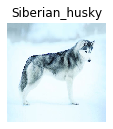

In [6]:
predict_tftrt('resnet50_saved_model_TFTRT_FP16')


In [4]:
def benchmark_tftrt(input_saved_model, batched_input):

    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 5
    N_run = 100
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 5 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-5:].mean()) * 100))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))




In [5]:
batch_size = 8
batched_input = tf.convert_to_tensor(np.zeros((batch_size, 224, 224, 3), dtype=np.float32))

benchmark_tftrt('resnet50_saved_model_TFTRT_FP16', batched_input)


Step 0:  1.1ms
Step 5:  1.2ms
Step 10:  1.1ms
Step 15:  1.1ms
Step 20:  1.1ms
Step 25:  1.1ms
Step 30:  1.1ms
Step 35:  1.1ms
Step 40:  1.2ms
Step 45:  1.1ms
Step 50:  1.1ms
Step 55:  1.1ms
Step 60:  1.0ms
Step 65:  1.1ms
Step 70:  1.1ms
Step 75:  1.1ms
Step 80:  1.1ms
Step 85:  1.1ms
Step 90:  1.0ms
Step 95:  1.1ms
Throughput: 91 images/s
